## How to plot 3 point time delay estimation velocity field

###### This jupyter notebook shows how to use a 3 point time delay estimation method and how to plot the resulting velocity field for W7X.

###### Documentation for the velocity estimation method can found here: https://github.com/uit-cosmo/velocity-estimation.

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import velocity_estimation.two_dim_velocity_estimates as tdve
import velocity_estimation.utils as u
from fppanalysis.running_moments import window_radius, run_norm_ds
import cosmoplots
import tde_functions

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Open dataset

###### Load data on hdf5 format and convert to xarray format

In [2]:
shot = 230323039
filename = 'Path to your h5 file'+str(shot).strip()+'.h5'
rad_pol_filename = np.load('Path to your rz array' + 'rz_arrs.npz')

### Load radial and poloidal coordinates

###### For rotated coordinates use rotation = True, else rotation = False

In [3]:
rotation = True
z_arr, r_arr, pol_arr, rad_arr = tde_functions.rad_pol_positions(rad_pol_filename)

if rotation:
    ds = tde_functions.create_xarray_from_hdf5(filename, rad_arr, pol_arr)
else:
    ds = tde_functions.create_xarray_from_hdf5(filename, r_arr, z_arr)

### For a given start and end time, slice the dataset

In [4]:
t_start = 7.1
t_end = 7.15
sliced_ds = ds.sel(time=slice(t_start, t_end))

### Detrend data

###### Choose cut off frequency that corresponds to window size for the running normalization. To decide this frequency, you can look at the periodogram. 
###### ```run_norm_ds``` computes a running normalization for the entire xarray dataset, for a given radius of the window. 
###### Documentation on running normalization can be found here: https://github.com/uit-cosmo/fpp-analysis-tools/blob/main/fppanalysis/running_moments.py 

In [5]:
cut_off_freq = 1e3
radius = window_radius(cut_off_freq, sliced_ds.time)
ds = run_norm_ds(sliced_ds, radius)

### Estimation options for velocity estimation

###### Estimation parameters are set in the EstimationOptions class, which is accepted as an argument of ```estimate_velocity_field()```.

In [6]:
eo = tdve.EstimationOptions()

###### By default a cross-correlation based method is used to estimate time delays. This can be changed by setting EstimationOptions.method.

In [7]:
print(eo.method)

TDEMethod.CC


###### Further time delay estimation options are specified in EstimationOptions.cc_options. Default values are shown below

In [8]:
print(eo.cc_options)

CC Window: None, Minimum CC Value: 0.5, Running Mean: True, Running Mean Window Max: 7, Interpolate: False


###### To use 3 point method to estimate velocities from time delays set this to True, to use 2 point method set to False

In [9]:
eo.use_3point_method = True

###### If running mean is True, a custom running mean algorithm will be employed on the cross correlation function. The width of the running mean is selected as the minimum width such that the resulting signal has only 1 local maxima. The width cannot be larger than ```running_mean_window_max```

In [10]:
eo.cc_options.running_mean = True

###### ```minimum_cc_value``` : Set a minimum cross correlation value needed to assign a velocity

In [11]:
eo.cc_options.minimum_cc_value = 0

##### NeighbourOption class contains options to control neighbor selection. 
###### ```ccf_min_lag```: Integer, checks that the maximal correlation between adjacent pixels occurs at a time larger or equal than neighbors_ccf_min_lag multiples of the discretization time.
###### ```min_separation``` : minimum allowed separation between pixels
###### ```max_separation``` : maximum allowed separation between pixels
###### By default ```max_separation``` = ```min_separation``` = 1 which means that only nearest neighbour will be used

In [12]:
print(eo.neighbour_options)

CCF Min Lag: -1, Max Separation: 1, Min Separation: 1


In [13]:
eo.neighbour_options = tdve.NeighbourOptions(ccf_min_lag=0)

### Generate velocities

###### ```estimate_velocity_field()``` will return a class containing estimated velocity data of all pixels.

In [14]:
movie_data = tdve.estimate_velocity_field(u.CModImagingDataInterface(ds), eo)
vx = movie_data.get_vx()
vy = movie_data.get_vy()
confidences = movie_data.get_confidences()
R = movie_data.get_R()
Z = movie_data.get_Z()

/Users/ahe104/opt/anaconda3/envs/fpp/lib/python3.10/site-packages/velocity_estimation/time_delay_estimation.py:609: UserWarning: Maximum running window achieved between pixels (6, 1) and (6, 0)
  warnings.warn("Maximum running window achieved " + extra_debug_info)
/Users/ahe104/opt/anaconda3/envs/fpp/lib/python3.10/site-packages/velocity_estimation/time_delay_estimation.py:609: UserWarning: Maximum running window achieved between pixels (7, 0) and (6, 0)
  warnings.warn("Maximum running window achieved " + extra_debug_info)
/Users/ahe104/opt/anaconda3/envs/fpp/lib/python3.10/site-packages/velocity_estimation/time_delay_estimation.py:609: UserWarning: Maximum running window achieved between pixels (7, 1) and (7, 0)
  warnings.warn("Maximum running window achieved " + extra_debug_info)
/Users/ahe104/opt/anaconda3/envs/fpp/lib/python3.10/site-packages/velocity_estimation/time_delay_estimation.py:609: UserWarning: Maximum running window achieved between pixels (6, 2) and (6, 1)
  warnings.

### Plot velocity field

Text(0.67, 1.015, 'time = 7.1 - 7.15 s')

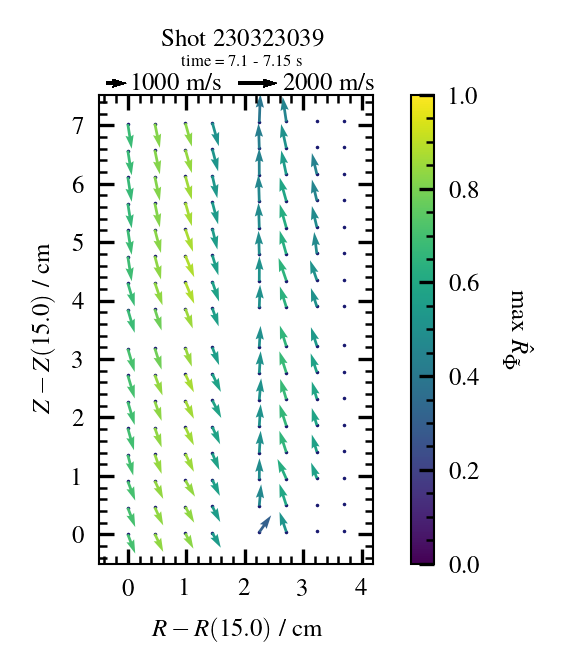

In [15]:
axes_size = cosmoplots.set_rcparams_dynamo(plt.rcParams, num_cols=1, ls="thin")
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["axes.labelsize"] = 6
plt.rcParams["xtick.labelsize"] = 6
plt.rcParams["ytick.labelsize"] = 6

fig = plt.figure()
ax = fig.add_axes(axes_size)

# Mark all pixels with a dot .
ax.scatter(R, Z, marker=".", color='midnightblue', s=0.5)

# Define default vmin and vmax values for colorbar
norm = mpl.colors.Normalize(vmin=0, vmax=1)

# Plot velocity field
qiv = ax.quiver(
    R,
    Z,
    vx,
    vy,
    confidences,
    scale=300000,
    scale_units="xy",
    angles="xy",
    norm=norm,
    width=0.01
)

# Plot arrows representing magnitude
qk = ax.quiverkey(
    qiv, 0.65, 1.025, 200000, r"$2000$ m/s", labelpos="E", coordinates="axes", fontproperties={'size':6}, labelsep=0.02,
)
qk = ax.quiverkey(
    qiv, 0.1, 1.025, 100000, r"$1000$ m/s", labelpos="E", coordinates="axes", fontproperties={'size':6}, labelsep=0.02,
)

# Plot colorbar
cbar = fig.colorbar(qiv, format="%.1f")
cbar.ax.set_ylabel(r"max $\hat{R}_{\tilde{{\Phi}}}$", rotation=270, labelpad=13)

if rotation:
    ax.set_xlabel(r"$R - R (15.0)$ / cm")
    ax.set_ylabel(r"$Z - Z (15.0)$ / cm")
    ax.set_ylim(min(Z[:,0]) - 0.5, max(Z[:,0] + 0.5))
    ax.set_xlim([min(R[0]) - 0.5, max(R[0]) + 0.5])
    plt.xticks(np.arange(round(min(R[0])), round(max(R[0]))+1, 1))
else:
    ax.set_xlabel(r"$R$ / cm")
    ax.set_ylabel(r"$Z$ / cm")
    ax.set_ylim(min(Z[:,0]) - 1.95, max(Z[:,0] + 0.6))
    ax.set_xlim([min(R[0]) - 3, max(R[0]) + 0.5])
    plt.xticks(np.arange(round(min(R[0])-2), round(max(R[0]))+1, 2))
    
ax.set_aspect("equal")

ax.set_title(rf"Shot {shot}" , fontsize=6,  x=0.53, y=1.05)
plt.suptitle(r'time = 'f'{t_start} - {t_end} s', fontsize=4, horizontalalignment='center', x=0.67, y=1.015)

###### To save the figure

In [ ]:
format = "pdf"
filename = f"tde_{shot}.{format}"
foldername = "Path where you want to save figure"
fig.savefig(
    foldername + filename, bbox_inches="tight", format=format
)